# DisPerSE & Filament Indentification Tutorial

This Jupyter notebook aims to teach you how to use the Discrete Persistent Structures Extractor (DisPerSE) to find galactic strustures like filaments and clusters. Much of the information in here can also be found on the DisPerSE website (https://www2.iap.fr/users/sousbie/web/html/indexd41d.html), which includes manuals and tutorials for all of DisPerSE's functions as well as more in depth explanations of how DisPerSE works.

Before getting into DisPerSE, I will import some of the libraries that will be used later on.

In [13]:
# Python Libraries
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.utils.data import download_file
import warnings
import os
import pandas as pd
from astropy.io import ascii

warnings.filterwarnings('ignore')

### Compiling and Installing DisPerSE

I was able to compile DisPerSE on a virtual machine running Ubuntu 20.04 via Windows WSL. DisPerSE can be downloaded from the aforementioned DisPerSE website or from the github (https://github.com/thierry-sousbie/DisPerSE). There are two required libraries/programs to be able to use the most basic functions of DisPerSE. They are CMake and GSL. You will also want CGAL which is used for the delaunay_2D/3D functions that output files in a format (.NDnet) that can be fed into other functions. 

Once you have DisPerSE downloaded, navigate to the "disperse/build" directory and type "cmake ../" to configure the make files. Then installing should be as simple as running "make install". You should then be able to find several executables in the "disperse/bin" folder, the most important ones are mse, delaunay_2D, delaunay_3D, and skelconv as these are the ones I used. There are also other functions, however, many of these are not essential.

### Making a DisPerSE Input File

The input DisPerSE takes in needs the coordinates of galaxies in the form of either RA, DEC, and Z or SGX, SGY, and SGZ. The easiest way to do this is to read out the contents of a catalog into an ascii text file, which is one of the file formats DisPerSE can read. You also need to name each column a specific keyword in the heading so that DisPerSE will recognize what that column's data represents. I will show an example of what I did below, but further examples of what this ascii file should look like can be found on https://www2.iap.fr/users/sousbie/web/html/index744c.html?post/survey_ascii-format.

In [14]:
# Defines a home directory and path to the catalog I want to use
homedir = os.getenv("HOME")
catalog_path='/home/evan-barkus/Downloads/'

In [15]:
# VFS main catalog
maintab = Table.read('/home/evan-barkus/Downloads/vf_v2_main.fits')

# VFS environment catalog (has SG coords)
envtab = Table.read('/home/evan-barkus/Downloads/vf_v2_environment.fits')

In [6]:
# Cuts on VFS catalog from Zakharova+24
racut = (maintab['RA'] > 100) & (maintab['RA'] < 280)
deccut = (maintab['DEC'] > -1.3) & (maintab['DEC'] < 75)
vrcut = (maintab['vr'] > 500) & (maintab['vr'] < 3300)
cut = vrcut & deccut & racut

cuttab = maintab[cut]

In [9]:
c = 3*10**5 #km/s

ra = np.array(cuttab['RA']) # Right ascension of each galaxy
dec = np.array(cuttab['DEC']) # Declination of each galaxy
z = np.array(cuttab['vr']/c) # Redshifts (VFS has recessional velocities so I had to convert them to z by dividing by c)

id = np.arange(0,len(ra)) # It is also useful to have a column of indices in the DisPerSE input file

In [12]:
# Defines the columns of the input file
col1 = fits.Column(name='ra', format='D', array=ra)
col2 = fits.Column(name='dec', format='D', array=dec)
col3 = fits.Column(name='z', format='D', array=z)
col4 = fits.Column(name='id', format='D', array=id)

In [13]:
# Combines columns and writes them into a fits table
coldefs = fits.ColDefs([col1, col2, col3, col4])
hdu = fits.BinTableHDU.from_columns([col1, col2, col3, col4])

In [ ]:
# Writes out the fits table "hdu" to a .txt file
ascii.write(hdu.data,'vfs_ascii_new',names=(['ra','dec','z','id']),overwrite=True)

And with that, we now have a file that DisPerSE can read.

### Running DisPerSE

The first thing you will want to do is run either delaunay_3D or delaunay_2D on this file. These output an unstructured network format file (.NDnet) that can be used as an input for other DisPerSE functions, namely mse, which is one of the most important functins in DisPerSE. The difference between the 3D and 2D versions is simply whether you included three or two position coordinates in your input file; DisPerSE should let you know if there are not enough arguments in the input to use them. To use either version, just run "<path>/disperse/bin/delaunay_nD filename" in your terminal. After running for a bit, delaunay_nD should generate a new file called "filename.NDnet".

You can then run mse on this output file. mse computes morse-smale complexes and finds structures. One important parameter of mse is '-nsig' which specifies a threshold for a structure detection as the number of sigmas. I used '-nsig 4' as this was used in Zakharova+24. Another parameter you will want to use is the '-upSkl' option. This is used to generate the output as a skeleton file (.NDskl), where the filament spines link together all of the maxima mse detects. You can use mse in the same way as you did delaunay_nD; just type "<path>/disperse/bin/mse filename.NDnet -nsig 4 -upSkl". You will get a new file named something like "filename.NDnet_s4.NDskl".

Another DisPerSE function you may use is skelconv. This function is useful for converting the skeleton file output of mse to a form that can be read into a python program and displayed. The option you will most likely want to use is '-to NDskl_ascii' which generates the output as an easy to read ascii file format.Again, simply run "<path>/disperse/bin/skelconv filename.NDnet_s4.NDskl -to NDskl_ascii".

You are now ready to start displaying the DisPerSE outputs and start identifying structures!

### Displaying DisPerSE Outputs

To display this data, I used a python program provided to me by Dr. Daria Zakharova. I have copied and pasted some of that program below. To run it on the skelconv output file you will need to edit the path to the file. I ran the program from my terminal using "python3 disperse_opener.py filename.NDnet_s4.a.NDskl". This program then reads the critcal points and filament spines to two '.csv' files and displays a 2-D plot of the spines and points in supergalactic coordinates, SGY and SGX. An example of what this plot should look like is also displayed below. 

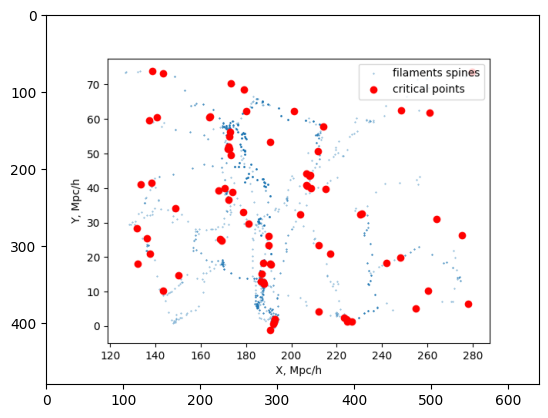

In [12]:
import matplotlib.image as mpimg

img = mpimg.imread('/home/evan-barkus/Figure_2.png')
imgplot = plt.imshow(img)
plt.show()

Here is the code from Dr. Zakharova.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 

NDskl_file_path = f"./vfs_ascii_SG (1)(1).NDnet_s4.up.NDskl.a.NDskl" # Edit this to be your .NDskl file


import io
import pandas as pd

def add_delimiters(fpath, delimiter=' '):
    s_data = []
    max_num_delimiters = 0

    with open(fpath, 'r') as f:
        for line in f:
            s_data.append(line.strip())  # Strip newline for consistency
            delimiter_count = line.count(delimiter)
            if delimiter_count > max_num_delimiters:
                max_num_delimiters = delimiter_count

    # Create a header row with placeholders if needed
    header = delimiter.join([f"col{i}" for i in range(max_num_delimiters + 1)])  
    s_data.insert(0, header)  # Prepend header
    
    return io.StringIO("\n".join(s_data))

ndskl = pd.read_csv(add_delimiters(NDskl_file_path), delim_whitespace=True)
# print(ndskl)


def get_crits(ndskl):
    crit_start = ndskl[ndskl.iloc[:, 0] == '[CRITICAL'].index[0] + 1 # find the critical points description in the a.NDskl file
    crit_end = ndskl[ndskl.iloc[:, 0] == '[FILAMENTS]'].index[0] - 1 # find the end of critical points description in the a.NDskl file
    crits = ndskl.iloc[crit_start:crit_end + 1] # slice the critical point info only
    n_suppose = crits.iloc[0,0] # the number of critical points identified by DisPerSE
    crits = crits[crits["col2"].notna()] # remove all auxilary info about critical points (only type, position, and density left)
    if n_suppose != crits.shape[0]: # check that the number of critical points is now th same as identified by DisPerSE
        print("The expected number of critical points is differ from the extracted")
   
    crits = crits.iloc[:, :7] # remove empty columns
    crits.columns = ["type_crit", "x", "y", "z", "dens", "pairID", "boundary"] 
    crits[["x", "y", "z", "dens"]] = crits[["x", "y", "z", "dens"]].astype("float64")
    
    return crits

def get_filaments(ndskl):
    fils_start = ndskl[ndskl.iloc[:, 0] == '[FILAMENTS]'].index[0] + 1
    fils_end = ndskl[ndskl.iloc[:, 0] == '[CRITICAL'].index[1] - 1
    fils = ndskl.iloc[fils_start:fils_end + 1]

    fils_data_start = ndskl[ndskl.iloc[:, 0] == '[FILAMENTS'].index[0] + 7 # 7 because firstly the names of field are listed
    fils_data_end = ndskl.shape[0]
    fils_data = ndskl.iloc[fils_data_start:fils_data_end + 1]

    n_fils = int(fils.iloc[0,0])
    counter = 0
    all_fils = []
    for i in range(n_fils):
        fil_len = int(fils.iloc[counter + 1, 2])
        fil = fils.iloc[(counter + 2) : (counter + 2 + fil_len), :]
        fil.loc[:, 'col3'] = i
        fil.loc[:, 'col4'] = fil_len
        counter += fil_len + 1
        all_fils.append(fil)
    fils = pd.concat(all_fils, ignore_index=True)

    fils = fils.iloc[:, :5]
    fils_data = fils_data.iloc[:, :5]

    fils.reset_index(drop=True, inplace=True)
    fils_data.reset_index(drop=True, inplace=True)
    
    fils = pd.concat([fils, fils_data], axis=1)

    fils.columns = ["x", "y", "z", "fils_number", "fil_len", "field_value", "orientation", "cell", "log_field_value", "type"]
    fils[["x", "y", "z"]] = fils[["x", "y", "z"]].astype("float64")
    return fils

crits = get_crits(ndskl)
fils = get_filaments(ndskl)

crits.to_csv("./critical_points.csv", index = False)  
fils.to_csv("./filaments_spines_3D.csv", index = False)  


plt.scatter(fils['x'], fils['y'], s = 0.1, label = "filaments spines")
plt.scatter(crits['x'], crits['y'], color = "red", label = "critical points")
plt.xlabel("X, Mpc/h")
plt.ylabel("Y, Mpc/h")
plt.legend()
plt.show()

### Finding the Virgo Cluster Center

The code above should output all of the critical points into a file named 'critical_points.csv'. These critical points will be in SGX and SGY with units of Mpc/h. They correspond to 3 types of critical point: saddle points, maxima, and minima. These critical points are computed using local densities, the number of galaxies per Mpc^3. To identify cluster members you want to look at maxima. Luckily one of the columns of 'critical_points.csv' is a local density for each critical point. This makes it easy to identify the center of the Virgo Cluster; you just have to find the critical point with the maximum density as I did below.

In [17]:
# Filaments and Critical Points
data = pd.read_csv(catalog_path+'/disperse_example/filaments_spines_3D.csv')
data2 = pd.read_csv(catalog_path+'/disperse_example/critical_points.csv')

In [18]:
virgo_cluster_center = max(data2['dens'])

# Finds which critical point corresponds to the center of the Virgo Cluster
dens = data2['dens']
for i in range(len(data2['dens'])):
    if dens[i] == virgo_cluster_center:
        print(i)

12


After finding which point the Virgo Cluster center was, the twelfth row, I found the coordinates of it.

In [24]:
sgx = data2['x']
sgy = data2['y']
sgz = data2['z']

VCx = sgx[11]
VCy = sgy[11]
VCz = sgz[11]

### Cutting Small Filaments

In Zakharova+24 they cut filaments shorter than 3 Mpc/h long because these were too short to be certain of. To remove these filaments, I used the boolean statements below on 'filament_spines_3D.csv'.

In [26]:
# Cuts all filaments less than 3 Mpc/h long
fil_len = data['fil_len']
cut = (fil_len >= 3.0)
cutdata = data[cut]

### Identifying Cluster Members

It is easiest to identify the cluster members first as these only have one criteria and they are excluded from the filaments. A galaxy is considered a cluster member if it is less than 3.6 Mpc/h from the Virgo Cluster center. Below is the code I wrote to find cluster members.

In [28]:
# VFS SG Coords
myTab = ascii.read('/home/evan-barkus/Downloads/vfs_ascii_SG (1)(1)')

# Galaxy Coords from VFS
x_gal = np.array(myTab['px'])
y_gal = np.array(myTab['py'])
z_gal = np.array(myTab['pz'])

# Critical Point Coords
x_crit = np.array(data2['x'])
y_crit = np.array(data2['y'])
z_crit = np.array(data2['z'])

In [29]:
ids = myTab['id'] # indices of the original VFS data

crit_x_gal = []
crit_y_gal = []
crit_z_gal = []
crit_dists_gal = []
crit_id = []
for i in range(len(myTab)):
    gal_id = ids[i]
    crit_dist = sqrt((VCx - x_gal[i])**2 + (VCy - y_gal[i])**2 + (VCz - z_gal[i])**2) # 3D distance from critical point in Mpc/h
    if (crit_dist <= 3.6): # A galaxy is a cluster member if it is with 3.6 Mpc/h of the Virgo cluster center
        crit_x_gal.append(x_gal[i]) # SGX
        crit_y_gal.append(y_gal[i]) # SGY
        crit_z_gal.append(z_gal[i]) # SGZ
        crit_dists_gal.append(crit_dist)
        crit_id.append(gal_id) # indices

In [30]:
len(crit_id)

402

### Identifying Filament Galaxies

Filament members are galaxies found within 2 Mpc/h of a filament spine and are not cluster members. 

In [32]:
# Filament Spine Coords
x_fil = np.array(data['x'])
y_fil = np.array(data['y'])
z_fil = np.array(data['z'])

# Filament and Cluster Members Coords, Distances from Filaments, and indices
ids = myTab['id'] # index corresponding to a specific galaxy

fil_crit_id = []
fil_crit_x_gal = []
fil_crit_y_gal = []
fil_crit_z_gal = []
fil_crit_dists_gal = []
for i in range(len(myTab)): # repeat for all VFS galaxies
    for j in range(len(data)): # repeat for all filament spine
        gal_id2 = ids[i] # indices of original VFS data
        fil_dist = sqrt((x_fil[j] - x_gal[i])**2 + (y_fil[j] - y_gal[i])**2 + (z_fil[j] - z_gal[i])**2) # 3D distance from filament spines in Mpc/h
        if (fil_dist <= 2): # Limits to galaxies within 2Mpc/h of a spine
            fil_crit_x_gal.append(x_gal[i]) # SGX
            fil_crit_y_gal.append(y_gal[i]) # SGY
            fil_crit_z_gal.append(z_gal[i]) # SGZ
            fil_crit_dists_gal.append(fil_dist) # distance from a filament spine
            fil_crit_id.append(gal_id2) # indices